# CPSC 330 - Applied Machine Learning 

## Homework 6: Putting it all together 
### Associated lectures: All material till lecture 13 

**Due date: Monday, June 13, 2022 at 18:00**

## Table of contents

- [Submission instructions](#si)
- [Understanding the problem](#1)
- [Data splitting](#2)
- [EDA](#3)
- (Optional) [Feature engineering](#4)
- [Preprocessing and transformations](#5)
- [Baseline model](#6)
- [Linear models](#7)
- [Different classifiers](#8)
- (Optional) [Feature selection](#9)
- [Hyperparameter optimization](#10)
- [Interpretation and feature importances](#11)
- [Results on the test set](#12)
- (Optional) [Explaining predictions](#13)
- [Summary of the results](#14)

## Imports 

In [1]:
import os

%matplotlib inline
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    f1_score,
    make_scorer,
    ConfusionMatrixDisplay,
)
from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    cross_val_score,
    cross_validate,
    train_test_split,
)
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.svm import SVC

/opt/miniconda3/envs/cpsc330/lib/python3.10/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


> If you get a `FutureWarning` regarding `pandas.Int64Index`, you can ignore it. It is because of a [known issue in `xgboost`](https://github.com/dmlc/xgboost/issues/7593).

<br><br>

## Instructions 
<hr>
rubric={points:2}

Follow the [homework submission instructions](https://github.com/UBC-CS/cpsc330-2022s/blob/master/docs/homework_instructions.md).

**You may work with a partner on this homework and submit your assignment as a group.** Below are some instructions on working as a group.
- The maximum group size is 2.
- Use group work as an opportunity to collaborate and learn new things from each other. 
- Be respectful to each other and make sure you understand all the concepts in the assignment well. 
- It's your responsibility to make sure that the assignment is submitted by one of the group members before the deadline. 
- You can find the instructions on how to do group submission on Gradescope [here](https://help.gradescope.com/article/m5qz2xsnjy-student-add-group-members).

<br><br>

## Introduction <a name="in"></a>
<hr>

At this point we are at the end of supervised machine learning part of the course. So in this homework, you will be working on an open-ended mini-project, where you will put all the different things you have learned so far together to solve an interesting problem.

A few notes and tips when you work on this mini-project: 

#### Tips

1. This mini-project is open-ended, and while working on it, there might be some situations where you'll have to use your own judgment and make your own decisions (as you would be doing when you work as a data scientist). Make sure you explain your decisions whenever necessary. 
2. **Do not include everything you ever tried in your submission** -- it's fine just to have your final code. That said, your code should be reproducible and well-documented. For example, if you chose your hyperparameters based on some hyperparameter optimization experiment, you should leave in the code for that experiment so that someone else could re-run it and obtain the same hyperparameters, rather than mysteriously just setting the hyperparameters to some (carefully chosen) values in your code. 
3. If you realize that you are repeating a lot of code try to organize it in functions. Clear presentation of your code, experiments, and results is the key to be successful in this lab. You may use code from lecture notes or previous lab solutions with appropriate attributions. 
4. If you are having trouble running models on your laptop because of the size of the dataset, you can create your train/test split in such a way that you have less data in the train split. If you end up doing this, please write a note to the grader in the submission explaining why you are doing it.  

#### Assessment

We plan to grade fairly and leniently. We don't have some secret target score that you need to achieve to get a good grade. **You'll be assessed on demonstration of mastery of course topics, clear presentation, and the quality of your analysis and results.** For example, if you just have a bunch of code and no text or figures, that's not good. If you do a bunch of sane things and get a lower accuracy than your friend, don't sweat it.

#### A final note

Finally, this style of this "project" question is different from other assignments. It'll be up to you to decide when you're "done" -- in fact, this is one of the hardest parts of real projects. But please don't spend WAY too much time on this... perhaps "a few hours" (2-8 hours???) is a good guideline for a typical submission. Of course if you're having fun you're welcome to spend as much time as you want! But, if so, try not to do it out of perfectionism or getting the best possible grade. Do it because you're learning and enjoying it. Students from the past cohorts have found such kind of labs useful and fun and I hope you enjoy it as well. 

<br><br>

## 1. Understanding the problem <a name="1"></a>
<hr>
rubric={points:4}

In this mini project, you will be working on a classification problem of predicting whether a credit card client will default or not. 
For this problem, you will use [Default of Credit Card Clients Dataset](https://www.kaggle.com/uciml/default-of-credit-card-clients-dataset). In this data set, there are 30,000 examples and 24 features, and the goal is to estimate whether a person will default (fail to pay) their credit card bills; this column is labeled "default.payment.next.month" in the data. The rest of the columns can be used as features. You may take some ideas and compare your results with [the associated research paper](https://www.sciencedirect.com/science/article/pii/S0957417407006719), which is available through [the UBC library](https://www.library.ubc.ca/). 

**Your tasks:**

1. Spend some time understanding the problem and what each feature means. You can find this information in the documentation on [the dataset page on Kaggle](https://www.kaggle.com/uciml/default-of-credit-card-clients-dataset). Write a few sentences on your initial thoughts on the problem and the dataset. 
2. Download the dataset and read it as a pandas dataframe. 

This is a spotting binary classification problem where the positive class and thing we wish to find is if a person defaults to their credit card bills. Although all features are numeric, some can be interpreted as categorical because they represent categories of that feature (such as education and marriage). The "pay" columns can have negative integers to represent no consumption, paid in full, the use of revolving credit, and payment delay for a number of months. Likewise, the "bill amount" columns may have a negative balance to represent a client overpaying their bill.

In [2]:
df = pd.read_csv("UCI_Credit_Card.csv")
df

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
0,1,20000.0,2,2,1,24,2,2,-1,-1,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,2,120000.0,2,2,2,26,-1,2,0,0,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,3,90000.0,2,2,2,34,0,0,0,0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,4,50000.0,2,2,1,37,0,0,0,0,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,5,50000.0,1,2,1,57,-1,0,-1,0,...,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,29996,220000.0,1,3,1,39,0,0,0,0,...,88004.0,31237.0,15980.0,8500.0,20000.0,5003.0,3047.0,5000.0,1000.0,0
29996,29997,150000.0,1,3,2,43,-1,-1,-1,-1,...,8979.0,5190.0,0.0,1837.0,3526.0,8998.0,129.0,0.0,0.0,0
29997,29998,30000.0,1,2,2,37,4,3,2,-1,...,20878.0,20582.0,19357.0,0.0,0.0,22000.0,4200.0,2000.0,3100.0,1
29998,29999,80000.0,1,3,1,41,1,-1,0,0,...,52774.0,11855.0,48944.0,85900.0,3409.0,1178.0,1926.0,52964.0,1804.0,1


<br><br>

## 2. Data splitting <a name="2"></a>
<hr>
rubric={points:2}

**Your tasks:**

1. Split the data into train and test portions. 

In [3]:
train_df, test_df = train_test_split(df, test_size=0.2, random_state=123)

<br><br>

## 3. EDA <a name="3"></a>
<hr>
rubric={points:10}

**Your tasks:**

1. Perform exploratory data analysis on the train set.
2. Include at least two summary statistics and two visualizations that you find useful, and accompany each one with a sentence explaining it.
3. Summarize your initial observations about the data. 
4. Pick appropriate metric/metrics for assessment. 

In [4]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24000 entries, 19682 to 19966
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   ID                          24000 non-null  int64  
 1   LIMIT_BAL                   24000 non-null  float64
 2   SEX                         24000 non-null  int64  
 3   EDUCATION                   24000 non-null  int64  
 4   MARRIAGE                    24000 non-null  int64  
 5   AGE                         24000 non-null  int64  
 6   PAY_0                       24000 non-null  int64  
 7   PAY_2                       24000 non-null  int64  
 8   PAY_3                       24000 non-null  int64  
 9   PAY_4                       24000 non-null  int64  
 10  PAY_5                       24000 non-null  int64  
 11  PAY_6                       24000 non-null  int64  
 12  BILL_AMT1                   24000 non-null  float64
 13  BILL_AMT2                  

All features are numeric, where some are float types and some are integer types. We will want to scale LIMIT_BAL, AGE, BILL_AMT, and PAY_AMT as the larger values would dominate.

In [5]:
train_df["default.payment.next.month"].value_counts()

0    18668
1     5332
Name: default.payment.next.month, dtype: int64

There is class imbalance as there are many cases of non-default compared to cases of default. We need to deal with it because in the training set, "most_frequent" strategy is labeling 18668 instances correctly and only 5332 instances incorrectly.

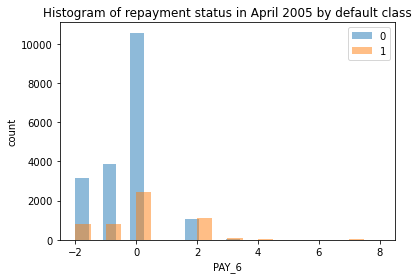

In [6]:
negative_examples = train_df.query('`default.payment.next.month` == 0')
positive_examples = train_df.query('`default.payment.next.month` == 1')
df_neg = negative_examples["PAY_6"]
df_pos = positive_examples["PAY_6"]
plt.hist(df_neg, alpha = 0.5, bins = 20, label = "0")
plt.hist(df_pos, alpha = 0.5, bins = 20, label = "1")
plt.xlabel("PAY_6")
plt.ylabel("count")
plt.title("Histogram of repayment status in April 2005 by default class")
plt.legend()
plt.show()

The histogram shows that clients with a repayment status of payment delay for 2 months or more in April 2005 are more likely to default than clients with a payment delay of under 2 months or none. We can conclude that repayment status is a factor that affects whether a client defaults or not.

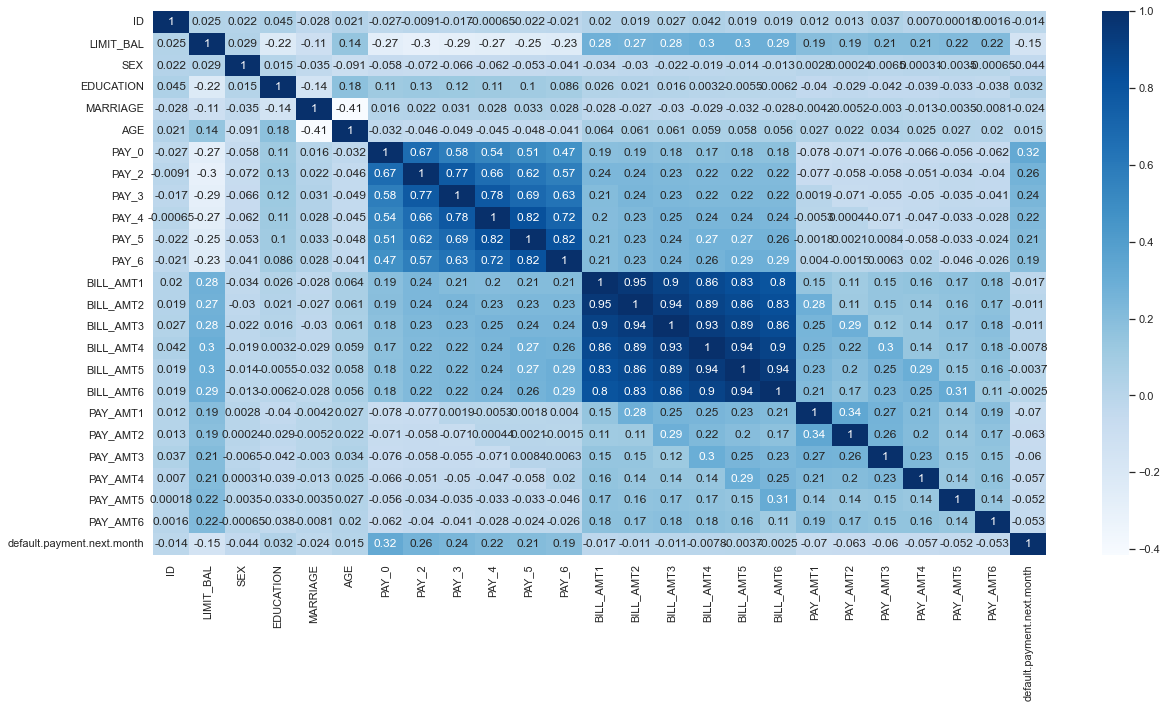

In [7]:
cor = train_df.corr()
plt.figure(figsize=(20, 10))
sns.set(font_scale=1)
sns.heatmap(cor, annot=True, cmap=plt.cm.Blues);

Looking at the feature correlations, we can see that default.payment.next.month has the highest correlation with PAY_0 (0.32). This tells us that PAY_0 is a useful feature in predicting if a customer will default or not.

After performing exploratory data analysis on the train set, we can see that some features have greater significance than others in predicting if a customer will default or not. Therefore, we can drop the less important features. Furthermore, the limit balance, age, bill amount, and pay features are numeric which will require scaling. However, the education and marriage features should be interpreted as categorical or ordinal features instead and do not require scaling. I noticed that the PAY_AMT features can have values of -2, -1, and 0. I concluded that -2 represents balance paid in full and no transactions this period, -1 represents balance paid in full but the account has a positive balance at end of the period from recent transactions for which the payment has not yet come due, and 0 represents minimum due amount paid but not the entire balance.

For this spotting problem, f1 score would be the best metric to use for assessment because we have an uneven class distribution and want to take both false positives and false negatives into account to seek a balance between precision and recall.

<br><br>

## (Optional) 4. Feature engineering <a name="4"></a>
<hr>
rubric={points:1}

**Your tasks:**

1. Carry out feature engineering. In other words, extract new features relevant for the problem and work with your new feature set in the following exercises. You may have to go back and forth between feature engineering and preprocessing. 

<br><br>

## 5. Preprocessing and transformations <a name="5"></a>
<hr>
rubric={points:10}

**Your tasks:**

1. Identify different feature types and the transformations you would apply on each feature type. 
2. Define a column transformer, if necessary. 

I am doing standard scaling on numeric features so that features with larger values do not dominate. I am doing one-hot encoding on categorical features to represent different categories where I cannot implement ordinality. I am dropping sex since it is a irrelevant feature that does not affect whether a client will default or not. I am passing education because it already has ordinality.

In [8]:
X_train = train_df.drop(columns=["default.payment.next.month"])
X_test = test_df.drop(columns=["default.payment.next.month"])

y_train = train_df["default.payment.next.month"]
y_test = test_df["default.payment.next.month"]

numeric_feats = ["ID", "LIMIT_BAL", "AGE", "BILL_AMT1", "BILL_AMT2", "BILL_AMT3", "BILL_AMT4", "BILL_AMT5",
                 "BILL_AMT6", "PAY_AMT1", "PAY_AMT2", "PAY_AMT3", "PAY_AMT4", "PAY_AMT5", "PAY_AMT6"]
drop_feats = ["SEX"]
categorical_feats = ["MARRIAGE", "PAY_0", "PAY_2", "PAY_3", "PAY_4", "PAY_5", "PAY_6"]
passthrough_feats = ["EDUCATION"]

ct = make_column_transformer(
    (StandardScaler(), numeric_feats),  # scaling on numeric features
    (OneHotEncoder(sparse=False, handle_unknown="ignore"), categorical_feats),  # OHE on categorical features
    ("passthrough", passthrough_feats),  # no transformations on the features with ordinality
    ("drop", drop_feats),  # drop the drop features
)
transformed = ct.fit_transform(X_train)

<br><br>

## 6. Baseline model <a name="6"></a>
<hr>

rubric={points:2}

**Your tasks:**
1. Try `scikit-learn`'s baseline model and report results.

In [9]:
dummy_pipe = make_pipeline(ct, DummyClassifier())
scores = cross_validate(
    dummy_pipe, X_train, y_train, return_train_score=True, scoring="f1"
)
pd.DataFrame(scores).mean()

fit_time       0.043797
score_time     0.015456
test_score     0.000000
train_score    0.000000
dtype: float64

From the results, the f1 scores for train and test are 0 because default = 0 is the most common, which tells us that we have no true positives when using the DummyClassifier. The output does not contain positive labels, making it impossible to compute precision. The fit time and score time is very low, which is expected with the baseline model as it is not complex.

<br><br>

## 7. Linear models <a name="7"></a>
<hr>
rubric={points:12}

**Your tasks:**

1. Try logistic regression as a first real attempt. 
2. Carry out hyperparameter tuning to explore different values for the complexity hyperparameter `C`. 
3. Report validation scores along with standard deviation. 
4. Summarize your results.

In [10]:
# from lecture 5
def mean_std_cross_val_scores(model, X_train, y_train, scoring = "f1", **kwargs):
    """
    Returns mean and std of cross validation

    Parameters
    ----------
    model :
        scikit-learn model
    X_train : numpy array or pandas DataFrame
        X in the training data
    y_train :
        y in the training data

    Returns
    ----------
        pandas Series with mean scores from cross_validation
    """

    scores = cross_validate(model, X_train, y_train, scoring = "f1", **kwargs)

    mean_scores = pd.DataFrame(scores).mean()
    std_scores = pd.DataFrame(scores).std()
    out_col = []

    for i in range(len(mean_scores)):
        out_col.append((f"%0.3f (+/- %0.3f)" % (mean_scores[i], std_scores[i])))

    return pd.Series(data=out_col, index=mean_scores.index)

In [11]:
results_dict = {}
results_df = {}
param_grid = {"C": np.logspace(-2, 2, 5)}

for param in param_grid["C"]:
    lr_pipe = make_pipeline(ct, LogisticRegression(max_iter=1000, C=param))

    key = "(C= " + str(param) + ")"
    results_dict[key] = mean_std_cross_val_scores(
        lr_pipe, X_train, y_train, scoring="f1", return_train_score=True
    )

results_df = pd.DataFrame(results_dict).T
results_df

,fit_time,score_time,test_score,train_score
(C= 0.01),0.181 (+/- 0.029),0.020 (+/- 0.001),0.427 (+/- 0.012),0.432 (+/- 0.008)
(C= 0.1),0.383 (+/- 0.048),0.020 (+/- 0.001),0.464 (+/- 0.018),0.469 (+/- 0.006)
(C= 1.0),0.691 (+/- 0.048),0.020 (+/- 0.001),0.466 (+/- 0.021),0.472 (+/- 0.005)
(C= 10.0),1.456 (+/- 0.171),0.021 (+/- 0.002),0.466 (+/- 0.021),0.472 (+/- 0.005)
(C= 100.0),2.159 (+/- 0.342),0.019 (+/- 0.000),0.466 (+/- 0.021),0.472 (+/- 0.005)


We achieve the best results when C = 1 because it produces the highest cross-validation score (0.466 +/- 0.021). The cross-validation score is around 47%, which represents the fact that about 53% of the clients in the training set will default and 47% will not. For C values greater than 1, the train/cross-validation scores do not increase anymore.

<br><br>

## 8. Different classifiers <a name="8"></a>
<hr>
rubric={points:15}

**Your tasks:**
1. Try at least 3 other models aside from logistic regression. At least one of these models should be a tree-based ensemble model (e.g., lgbm, random forest, xgboost). 
2. Summarize your results. Can you beat logistic regression? 

In [12]:
results = {}
# RBF SVM
svc_pipe = make_pipeline(ct, SVC())
results["SVC"] = mean_std_cross_val_scores(
    svc_pipe, X_train, y_train, scoring="f1", return_train_score=True
)

In [13]:
# RandomForestClassifier
rf_pipe = make_pipeline(ct, RandomForestClassifier(random_state=123))
results["RandomForestClassifier"] = mean_std_cross_val_scores(
    rf_pipe, X_train, y_train, return_train_score=True, scoring="f1"
)

In [14]:
# XGBoost
xgb_pipe = make_pipeline(ct, XGBClassifier(random_state=123, eval_metric="logloss", verbosity=0, 
                                           use_label_encoder=False))
results["XGBoost"] = mean_std_cross_val_scores(
        xgb_pipe, X_train, y_train, scoring="f1", return_train_score=True
)

results_df = pd.DataFrame(results).T
results_df

,fit_time,score_time,test_score,train_score
SVC,41.451 (+/- 4.365),10.034 (+/- 0.614),0.438 (+/- 0.024),0.455 (+/- 0.003)
RandomForestClassifier,88.879 (+/- 4.574),0.133 (+/- 0.005),0.472 (+/- 0.020),1.000 (+/- 0.000)
XGBoost,9.922 (+/- 1.646),0.038 (+/- 0.007),0.456 (+/- 0.015),0.723 (+/- 0.005)


Both SVC and XGBoost models have lower cross-validation scores than Logistic Regression. RandomForestClassifier gives the highest cross-validation score (0.472 +/- 0.020) compared to all the models. However, it does have the highest fit time compared to the other models and it is overfitting.

<br><br>

## (Optional) 9. Feature selection <a name="9"></a>
<hr>
rubric={points:1}

**Your tasks:**

Make some attempts to select relevant features. You may try `RFECV` or forward selection. Do the results improve with feature selection? Summarize your results. If you see improvements in the results, keep feature selection in your pipeline. If not, you may abandon it in the next exercises. 

<br><br>

## 10. Hyperparameter optimization <a name="10"></a>
<hr>
rubric={points:15}

**Your tasks:**

Make some attempts to optimize hyperparameters for the models you've tried and summarize your results. You may pick one of the best performing models from the previous exercise and tune hyperparameters only for that model. You may use `sklearn`'s methods for hyperparameter optimization or fancier Bayesian optimization methods. 
  - [GridSearchCV](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html)   
  - [RandomizedSearchCV](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html)
  - [scikit-optimize](https://github.com/scikit-optimize/scikit-optimize)

In [15]:
param_grid = {
    "randomforestclassifier__n_estimators": [1, 5, 10, 50, 100],
    "randomforestclassifier__max_depth": [1, 3, 5, 10, 15, 20],
}

random_search = RandomizedSearchCV(
    rf_pipe, param_distributions=param_grid, n_jobs=-1, n_iter=10, cv=5, random_state=123
)
random_search.fit(X_train, y_train);
pd.DataFrame(random_search.cv_results_).T

,0,1,2,3,4,5,6,7,8,9
mean_fit_time,12.650287,239.756079,1.458709,10.541856,57.951383,20.730307,15.099285,10.092174,7.650613,87.635431
std_fit_time,0.146354,15.975646,0.164451,0.803498,0.86988,1.172702,0.34795,0.565802,0.343283,21.414332
mean_score_time,0.031534,0.183834,0.02951,0.03074,0.053594,0.038547,0.030439,0.028962,0.026215,0.074214
std_score_time,0.000706,0.005202,0.008301,0.000775,0.000488,0.000832,0.001471,0.000317,0.001526,0.014527
param_randomforestclassifier__n_estimators,10,100,1,5,50,10,10,5,5,50
param_randomforestclassifier__max_depth,3,20,3,20,3,20,5,15,5,15
params,"{'randomforestclassifier__n_estimators': 10, '...","{'randomforestclassifier__n_estimators': 100, ...","{'randomforestclassifier__n_estimators': 1, 'r...","{'randomforestclassifier__n_estimators': 5, 'r...","{'randomforestclassifier__n_estimators': 50, '...","{'randomforestclassifier__n_estimators': 10, '...","{'randomforestclassifier__n_estimators': 10, '...","{'randomforestclassifier__n_estimators': 5, 'r...","{'randomforestclassifier__n_estimators': 5, 'r...","{'randomforestclassifier__n_estimators': 50, '..."
split0_test_score,0.805417,0.815,0.807083,0.799167,0.796875,0.802708,0.808542,0.798958,0.805625,0.812708
split1_test_score,0.809583,0.816667,0.813333,0.791875,0.801042,0.807292,0.816042,0.807917,0.811458,0.815625
split2_test_score,0.796458,0.820625,0.793125,0.803125,0.796458,0.81125,0.805833,0.802292,0.80625,0.815417


I optimized hyperparameters, n_estimators and max_depth for RandomForestClassifier using RandomizedSearchCV. I picked a wide range of values because the greater they are, the more complex the model is. I receive the best mean cross-validation score of 0.820375 when n_estimators is 100 and max_depth is 20. This score is 0.348 higher than the score produced from using the default values for RandomForestClassifier.

<br><br>

## 11. Interpretation and feature importances <a name="1"></a>
<hr>
rubric={points:15}

**Your tasks:**

1. Use the methods we saw in class (e.g., `eli5`, `shap`) (or any other methods of your choice) to explain feature importances of one of the best performing models. Summarize your observations. 

In [16]:
import eli5
import warnings

rf_pipe = make_pipeline(ct, RandomForestClassifier(n_estimators=100, max_depth=20, random_state=123))
rf_pipe.fit(X_train, y_train)

column_names = (
    numeric_feats
    + ct.named_transformers_["onehotencoder"].get_feature_names_out().tolist()
    + passthrough_feats
)
warnings.simplefilter(action="ignore", category=UserWarning)  # ignore warnings
warnings.simplefilter(action="default", category=UserWarning)  # reactivate warnings

eli5_rf = eli5.explain_weights(rf_pipe.named_steps["randomforestclassifier"], feature_names=column_names)
eli5_rf

Weight,Feature
0.0848 ± 0.1040,PAY_0_2
0.0539 ± 0.0105,ID
0.0490 ± 0.0119,BILL_AMT1
0.0473 ± 0.0124,BILL_AMT2
0.0464 ± 0.0160,LIMIT_BAL
0.0455 ± 0.0097,AGE
0.0451 ± 0.0189,PAY_AMT1
0.0441 ± 0.0101,BILL_AMT3
0.0437 ± 0.0104,BILL_AMT6
0.0434 ± 0.0095,BILL_AMT4


The PAY_0_2 feature is the most important feature according to eli5 for the RandomForestClassifier. This feature has a weight of 0.0848 +/- 0.1040 and represents clients who have a payment delay of 2 months.

<br><br>

## 12. Results on the test set <a name="12"></a>
<hr>

rubric={points:5}

**Your tasks:**

1. Try your best performing model on the test data and report test scores. 
2. Do the test scores agree with the validation scores from before? To what extent do you trust your results? Do you think you've had issues with optimization bias? 

In [17]:
random_search.score(X_test, y_test)

0.8211666666666667

The test score is very close to the cross-validation score (0.820375), and in fact the test score is slightly higher, which confirms that this is due to luck and randomness. I believe there is optimization bias because I compared many models and some of these could have a low validation error by chance.

<br><br>

## (Optional) 13. Explaining predictions 
rubric={points:1}

**Your tasks**

1. Take one or two test predictions and explain them with SHAP force plots.  

<br><br>

## 14. Summary of results <a name="13"></a>
<hr>
rubric={points:10}

**Your tasks:**

1. Report your final test score along with the metric you used. 
2. Write concluding remarks.
3. Discuss other ideas that you did not try but could potentially improve the performance/interpretability . 

My final test score for the f1 score metric is 0.82117 for a RandomForestClassifier with n_estimators = 100 and max_depth = 20. The test score is slightly higher than the validation score from before, due to luck and randomness. After trying several models, RandomForestClassifier produced the highest cross-validation score when the parameters, n_estimators and max_depth were optimized. I did not try LightGBM and CatBoost, which could have produced a higher cross-validation score. I did not try feature selection, which could have improved the performance and interpretability of my model by discarding the least important features. Also I did not perform feature engineering, which could have improved the performance/interpretability of my model through creating new relevant features.

<br><br><br><br>

## Submission instructions 

**PLEASE READ:** When you are ready to submit your assignment do the following:

1. Run all cells in your notebook to make sure there are no errors by doing `Kernel -> Restart Kernel and Clear All Outputs` and then `Run -> Run All Cells`. 
2. Notebooks with cell execution numbers out of order or not starting from “1” will have marks deducted. Notebooks without the output displayed may not be graded at all (because we need to see the output in order to grade your work).
3. Upload the assignment using Gradescope's drag and drop tool. Check out this [Gradescope Student Guide](https://lthub.ubc.ca/guides/gradescope-student-guide/) if you need help with Gradescope submission. 